In [ ]:
%%javascript  # Allow equation numbers
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy import units
from astropy import constants
from astropy.table import QTable
from astropy.visualization import quantity_support
from IPython.display import set_matplotlib_formats
import scipy.integrate as integ

quantity_support()
set_matplotlib_formats('svg')
plt.rc('legend', frameon=False)

# Project 3: "La Palma": Anatomy of a sunspot

#### Candidate numbers: 15908 and 15904

What are sunspots? This is a question scientiests still ask, and a phenomenon we try to learn more about.  
We want to use spectral observations of the Sun, taken at the Roque de Los Muchachos Observatory with the Swedish 1-m Solar Telescope (SST) at La Palma, in order to learn more about these dark spots appearing on the Sun's photosphere. Among other things, we want to determine the parameters of the atmosphere, investigate brightness temperature, velocities, and magnetic fields, in order to tell us more about the sunspot, how it compares with the solar granulation around, and its properties. By use of this dataset, we can create plots in order to better understand the behaviour of these different areas, and possible connections between the different properties.  
From the observations, we get values for the intensity [W / (Hz m2 sr)], Stokes V (circular polarisation) [W / (Hz m2 sr)] and the wavelength [nm]. There are 13 wavelengths, roughly covering the FeI 617 nm line profile. First we can plot the intensities for one specific wavelength at 617.268 nm read from the received dataset in order to get a better understanding of the looks of a sunspot. 

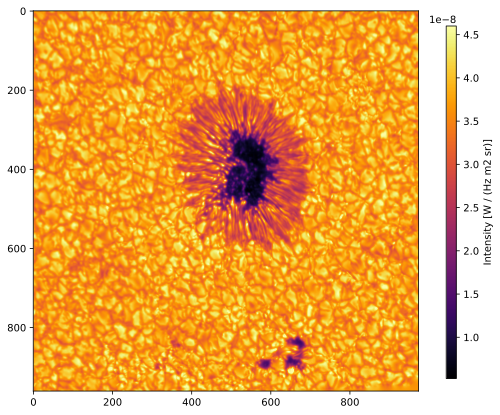

In [3]:
# Define variables:
e = constants.e.si         # electron charge
c = constants.c            # speed of light
m_e = constants.m_e        # mass of electron
k_B = constants.k_B        # Boltzmann constant
h = constants.h            # Planck constant

# Read observations from data set:
data = QTable.read('SST_sunspot_617_2020.08.07.fits')

# Extract data vectors used later:
Stokes_V = data["stokes_v"]
intensity = data["intensity"]
lam = data["wavelength"]   # Observed Doppler-shifted wavelength

# Plotting the intensity:
fig, ax = plt.subplots(figsize=(7,7))                              # Defining figure
im_I = ax.imshow(intensity[0].value, vmax=4.6e-8, cmap='inferno'); # Creating image
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])                    # Fixing colorbar position
cbar_ax.tick_params(labelsize=10)                                  # Setting textsize of colorbar
cbar = fig.colorbar(im_I, cax=cbar_ax)                             # Inserting the colorbar into the image
cbar.set_label("Intensity [W / (Hz m2 sr)]",size=10)               # Setting label of the colorbar

In the plot presented above we see the observed intensity from a sunspot, consisting of an umbra and a penumbra. The darkest area in the middle where the intensity is low is called the umbra, the surrounded slightly ligther area is called the penumbra, the yellow dots covering the larger area where the intensity is higher are called the granulation, and the three dark spots in the bottom right corner of the plot is called pores. We observe that they also have a lower intensity in comparison with the surroundings, but are lacking their own penumbra. These different areas can also be visualized in a spectral line plot, where the normalized intensity of a certain (x,y) point is plottet as a function of wavelength.

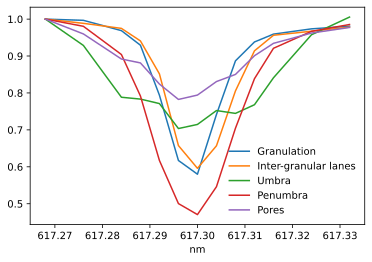

In [4]:
# Plotting the intensity of different regions of the Sun scaled by their continues intensity:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(lam, intensity[:, 200, 200]/intensity[0, 200, 200], label='Granulation')
ax.plot(lam, intensity[:, 800, 200]/intensity[0, 800, 200], label='Inter-granular lanes')
ax.plot(lam, intensity[:, 400, 550]/intensity[0, 400, 550], label='Umbra')
ax.plot(lam, intensity[:, 400, 450]/intensity[0, 400, 450], label='Penumbra')
ax.plot(lam, intensity[:, 900, 590]/intensity[0, 900, 590], label='Pores')
ax.legend();

The results from this plot, showing the spectral line of the iron line, indicate that there is less iron in the umbra and the pores, and that there is more iron in the penumbra. We also observe that the broadening of the lines representing the pores and the umbra is greater. This is an interesting observation, which may have a connection with other properties of the sunspot like the magnetic field.


These sunspots can be large, and exactly this sunspot can be compared with the size of the Earth by looking at the pixels in the first intensity plot, where one pixel corresponds to 42.46 km on the solar surface. If we assume that the sunspot is circular and approximate it to the size 350 $\times$ 350 pixels, that the area of the Earth is approximately 128 $\cdot$10$^6$ km$^2$ and that the Earth radius is 6371 km, we can find the size of the sunspot compared to the Earth. 

The earth is 73.52 percent the size of the sunspot


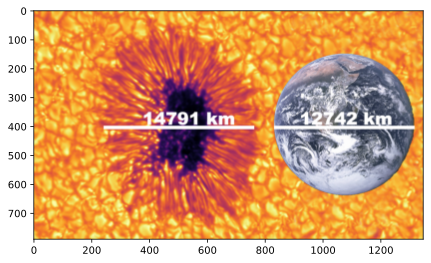

In [5]:
# Calculating the sunspot size compared to Earth:
area_sunspot = np.pi * (175*42.46)**2 # Sunspot area. Radius is 350 pixels divided by two
area_earth = np.pi * 6371 ** 2        # Approximated Earth area
percent = (area_earth*100) / area_sunspot
print("The earth is %.2f percent the size of the sunspot" %percent)

# Plot illustration of size:
from PIL import Image
sunspot_earth = Image.open("sunspot_earth2.png")
fig, ax = plt.subplots(figsize=(7,7))
im_scale = ax.imshow(sunspot_earth);

In the image presented above, we observe that the Earth is approximately 73.52 % the size of the sunspot, which is quite big. Now that we have a certain impression of the size and looks of this sunspot, we want to learn more about its properties. 


First, we want to find the brightness temperature $T_b$ and the velocities, in order to investigate the dynamics of the solar granulation and the sunspot, and how they are moving in relation to us. If we look at the frequency related Planck function

\begin{align}
\tag{1}
B_{\nu}(T) = \frac{2 h \nu^3}{c^2} \frac{1}{e^{\frac{h \nu}{k_B T} - 1}},
\tag{1}
\end{align}

and assume the Sun is a black body, we can find the brightness temperature since the Planck function gives us a connection with the observed intensity

\begin{align}
\tag{2}
B_{\nu}(T_b) = I_{\nu}^{\text{obs}}.
\tag{2}
\end{align}

This means that $T_b$ from the continuum intensity is most likely very close to the effective temperature of the star, which indicates that we can use $I$ and $\lambda$ from the dataset, calculate $T_b$ and approximate the effectiv temperature with this. We want to use $\lambda = 617.268$ nm and the intensity at this wavelength since this is the furthest away from the spectral line we get. If we had measured the temperature at the spectral line, our assumption that effectiv temperature equals brightness temperature would be wrong. 

When looking at Eq.(1) and assuming radiation from a black body, since we already know the intensity $I_{\nu}^{\text{obs}}$ from the observations, we can easy find the frequency $\nu$ values by use of the wavelength values from the observations, and then rewrite Eq.(1) in order to find $T_b$. By rewriting, we obtain

\begin{align}
\tag{3}
T_b = \Big( \text{ln} \Big( \frac{2h c}{\lambda^3 I_{\nu}}  +1 \Big) \frac{k}{h \nu} \Big)^{-1}.
\tag{3}
\end{align}


In order to solve this, we use the collected observations read from file. Then, by use of constants collected from $\verb|astropy|$ and Eq.(3), we find the brightness temperature. We then create a plot in order to observe the temperature in the sunspot, granulation area and the pores.

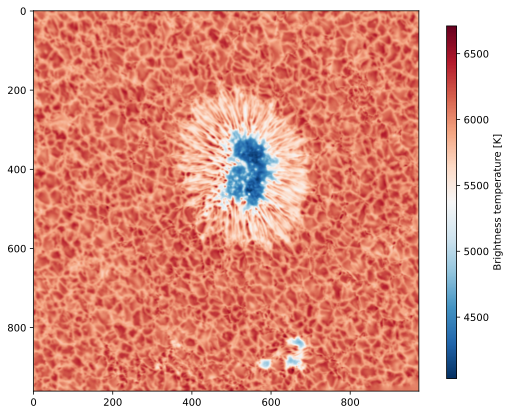

In [6]:
def T_b():
    """ Calculate brightness temperature """
    T_brightness = 1 / (np.log((2*h*(c))/(lam[0]**3 * intensity[0])/units.sr + 1) * (k_B / (h*(c/lam[0]))))
    return T_brightness.to("K")

# Plot brightness temperature:
fig, ax = plt.subplots(figsize=(7,7))
im1 = ax.imshow(T_b().value, cmap='RdBu_r');
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar_ax.tick_params(labelsize=10)
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label("Brightness temperature [K]",size=10)

In the plot presented above, visualizing the brightness temperature, we observe that the temperature of the whole sunspot (including the umbra and the surrounded penumbra) is lower than the brightness temperature of the granulation. We also observe that the brightness temperature in the umbra is lower than in the penumbra. The temperature of the pores in the bottom right corner, is also lower than the temperature in the granulation, though they are not as low as the umbra's temperature. 


Next, we want to calculate the velocity in order to interpret how the matter is moving in relation to the surface of the Sun.  We need to take the shiftning of the velocity that occurs due to the Doppler effect into account, represened by the general formula

\begin{align}
\tag{4}
\frac{ \lambda_0 - \lambda}{\lambda_0} = \frac{\Delta \lambda}{\lambda_0} = \frac{v}{c},
\end{align}

where $\lambda = \lambda_{\text{shifted}}$ which is the Doppler shiftet wavelength, $v$ is the velocity of the body, and we use the rest wavelength $\lambda_0$= 617.300 nm. This formula is useful, since spectral lines also gets Doppler shiftet, so by finding the shiftet wavelength from the shiftet spectral line and by use of the Doppler shift equation, we can determine the velocity, which in our case will be the velocty along the line of sight, $v = v_{\text{los}}$. By use of this definition, a negative velocity indicates that the body is moving away from us, which is called red-shift, and a positive velocity indicates that the body is moving towards us, called blue-shift. 

The actual velocticy, which we want to find, is given by

\begin{align}
\tag{5}
v = \frac{v_{\text{los}}}{\text{cos}\theta},
\end{align}

where $v_{\text{los}}$ is the velocity found by use of Eq.(4) and $\theta$ is the angle between line of sight and the normal of the emitting surface. So first we need to find the angle $\theta$, and this can be done by use of simple geometry.

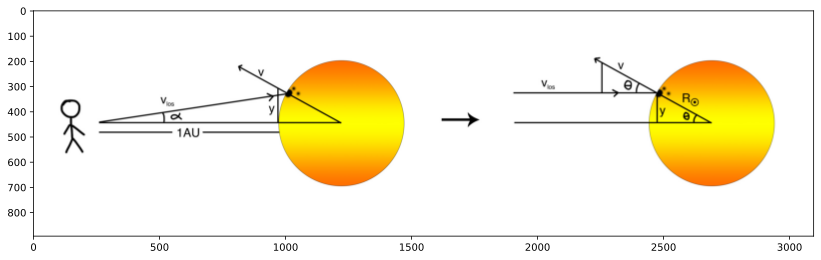

In [7]:
# Open illustration:
from PIL import Image
sunspot_earth = Image.open("figur_theta.jpg")
fig, ax = plt.subplots(figsize=(14,14))
im_scale = ax.imshow(sunspot_earth);

The centre of the intensity plot is (x, y) = (-473", 248") in Helioprojective cartesian coordinates, and the center of the solar disk is at (0, 0). We assume that we are so far away that the line of sight to the sunspot and the position vector between the Sun and the Earth are entering parallel, and that the height $y$ is approximately the same in the illustration to the left and right. We can then find the angle $\alpha$, the height $y$, and then angle $\theta$. We get that

\begin{align*}
\alpha = \sqrt{(248")^2 + (473")^2},
\end{align*}

and by use of small angle approximation we get that $y$ is

\begin{align*}
y = 1 AU \alpha.
\end{align*}

Since we say that the height $y$ of the triangle in the figure to the left in the illustration is approximately the same as $y$ in the triangle in the figure to the right, and we get that

\begin{align*}
\theta = \text{arcsin} \Big( \frac{y}{\text{R}_{\odot}} \Big),
\end{align*}

and then we simply get cos$\theta$ by taking the cosine of the answer above.

In [8]:
# Calculating the cosin to theta
alpha = np.sqrt((248**2) + (473**2)) / (3600*360)*2*np.pi
y = constants.au * alpha
theta = np.arcsin(y/constants.R_sun)
cos_theta = np.cos(theta)

The next thing we need to find is the Doppler shifted wavelength $\lambda_{\text{shifted}}$, which is the wavelength where the spectral line has its peak, the velocity shift. To find this we can estimate the mean value of wavelength, by pretending to use the line profile as a gaussian probability distribution function(PDF) and scaling the result by the integral over the pretended PDF,

\begin{align}
\tag{6}
\lambda_{\text{shifted}} = \frac{\int \lambda I_{\lambda} d\lambda}{\int I_{\lambda} d\lambda},
\end{align}

where the intensities and wavelengths are read from the observational data. We also need to invert the line profile into an emission line for this calcualtion to work, since the PDF is expected to be higher at the wavelength of FeI. We can do this simply by subtracting the highest value of the intensity by the whole intensity vector at all points in our dataset.

\begin{align}
\tag{7}
I_{\text{inv}} = I_{\text{max}} - I
\end{align}

This inversion also scales our PDF nicely such that the continuum intensity has a value of zero.  
This calculation takes a few minutes, so in order to save time it is wise to run the calculation of $\lambda_{\text{shifted}}$ one time and save the results in a file which can be loaded when later needed. After this is done we can calculate $v_{\text{los}}$ and then $v$, and create a plot of the velocity of the body in order to observe where the matter is moving compared to the surface. When plotting we will use blue as the direction towards us, and red away from us since this is what coincides with red and blue shift.

In [9]:
# Calcualte the shift of wavelength:
def lam_shifted_calc(data):
    """ Calculating the doppler shifted wavelength """
    integral_1 = np.zeros(intensity[0].shape)
    integral_2 = np.zeros(intensity[0].shape)
    intensity_ = np.zeros(intensity.shape)

    for i in range(len(data["intensity"])):
        intensity_[i] = intensity[0].value - intensity[i].value

    for i in range(len(intensity[0])):
        for j in range(len(intensity[0][0])):
            integral_1[i, j] = integ.trapz(lam.value * intensity_[:, i, j], lam.value)
            integral_2[i, j] = integ.trapz(intensity_[:, i, j], lam.value)
    lam_shifted = integral_1 / integral_2   # Calculating the shift in wavelegth caused by velocity shift
    np.save("lam_shifted.npy", lam_shifted) # Saving the values to a npy file for later use

#lam_shifted_calc(data)

In [10]:
lam0 = 617.300 * units.nm   # Original wavelength of spectral line

# Load the shifted wavelength:
lam_shifted_load = np.load("lam_shifted.npy")
lam_new =  lam_shifted_load * units.nm

# Line of sight velocity:
def v_los(lam0, lam_new): 
    v_lineofsight = c * ((lam0 - lam_new)/lam0)
    return v_lineofsight.to("km/s")

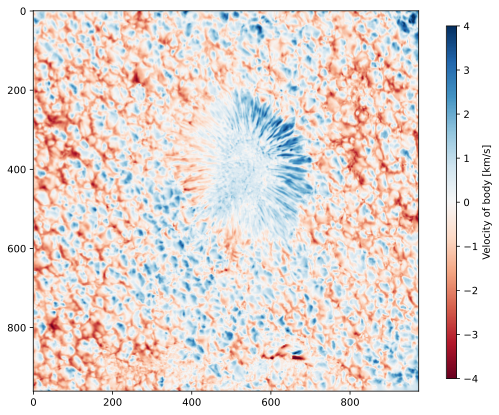

In [11]:
# Velocity:
def v(v_los,cos_theta): 
    velocity = v_los/cos_theta
    return velocity

fig, ax = plt.subplots(figsize=(7,7))
im_v = ax.imshow(v(v_los(lam0, lam_new),cos_theta), vmax=4, vmin=-4, cmap='RdBu');
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar_ax.tick_params(labelsize=10)
cbar = fig.colorbar(im_v, cax=cbar_ax)
cbar.set_label("Velocity of body [km/s]",size=10)
plt.show()

From the plot presented above, we observe that the matter in the sunspot is moving mostly away from the surface. On the right side of the penumbra the velocity is very blue-shifted, and the velocity on the left side is less so. There are even some parts of the edge of the penumbra which look red-shifted. The velocity in the umbra seems to be close to zero. We also observe that the velocity measured in granulation area on the upper right side to the penumbra is generally more red-shifted, and that the velocity in the granulation area on the lower left side of the penumbra is on average more blue-shifted. A possible explanation to this can be that matter is moving in a circular like shape up from the right side of the penumbra, over the umbra, and down again on the left side. Another possibility can be that matter is moving up from the right side of the penumbra and down again on the granulation area to the right, and same with the left side. We also observe that there are no remarkable velocities detected in the pores, but we observe two smaller areas between two of the pores where the velocities are higher, one tiny area moving towards the surface and another away from the surface. A possible reason for this might be that matter is moving from one pore to the other.

In addition, the estimation of $\lambda_{\text{shifted}}$ will have a corresponding variance $\sigma^2$. The variance can be given by the estimated value of the difference between the wavelength and $\lambda_{\text{shifted}}$ squared, scaled in the same way as we did with $\lambda_{\text{shifted}}$. This gives us a variance

\begin{equation}
\tag{8}
\sigma^2 = \frac{\int (\lambda - \mu)^2 I_{\lambda} d \lambda}{\int I_{\lambda} d \lambda}
\end{equation}

which we can calculate.

In [12]:
# Calcualte the wavelength variance of a dataset:

def sig_calc(data):
    """ Calculating the variance """
    # Setting up empty temporary arrays for integration
    integral_3 = np.zeros(intensity[0].shape)
    integral_4 = np.zeros(intensity[0].shape)
    intensity_ = np.zeros(intensity.shape)
    
    # Inverting the intensity to a Gaussian-like curve
    for i in range(len(data["intensity"])):
        intensity_[i] = intensity[0].value - intensity[i].value
    
    # Looping through all pixels and calculating the integrals over wavelength
    for i in range(len(intensity[0])):
        for j in range(len(intensity[0][0])):
            integral_3[i, j] = integ.trapz( ((lam.value - lam_shifted_load[i,j])**2)*intensity_[:,i,j], lam.value)
            integral_4[i, j] = integ.trapz(intensity_[:, i, j], lam.value)

    sigma2 = integral_3 / integral_4  # Calculating the variance
    np.save("sigma2.npy", sigma2)     # Saving the values to a npy file for later use

#sig_calc(data)

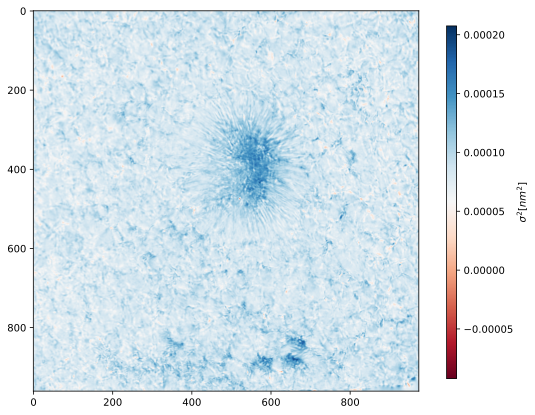

In [13]:
sigma2 = np.load("sigma2.npy") * units.nm ** 2 # Loading the variance from file

fig, ax = plt.subplots(figsize=(7,7))
im_sigma = ax.imshow(sigma2, cmap='RdBu');
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar_ax.tick_params(labelsize=10)
cbar = fig.colorbar(im_sigma, cax=cbar_ax)
cbar.set_label("$\sigma^2 [nm^2]$",size=10)

We can see from this plot that the sunspot umbra has a larger variance than the general granulation area. We can also see that the pores have a larger variance than the granulation area, just like the umbra. It is also possible to make out the penumbra from a 
characteristic line structure around the umbra, though this area seems to have approximatelly the same variance values as the granulation area.  
We should note that we get some negative variance at very small points scattered around the granulation area. This must be a numerical error, since it should be impossible to have a negative variance.

The variance is used to estimate the broadening of the absorption line, at different points in the Sun. One effect which leads to broadening in the line profile is the Zeeman effect. The Zeeman effect is a splitting of a spectral line as a result of a magnetic field splitting the energy levels of an excited electron. Then there are two very simular excitations and photons, at a larger interval of wavelength then we otherwise would expect, are scattered. These two energy levels are so close to eachother that they will appear as a single spectral line, just wider than we would expect without this effect. From Project 3: "La Palma": Anatomy of a sunspot (Pereira, 2020) the two energy levels will be split in the wavelength range by an interval

\begin{equation}
\tag{9}
\lambda_{B} = \frac{e \lambda_0 B}{4 \pi m_e c},
\end{equation}

which is propotional to the magnetic field. Here we have $e$ which is the electron charge, $\lambda_0$ which is the wavelngth of the spectral line, $m_e$ is the electron mass and $c$ is the speed of light. By combining this result with the circular polarisation of light, Stokes V, and assuming that the Weak Field Approximation is true, it is possible to show that the observed magnetic flux density can be given by as

\begin{equation}
\tag{10}
B_{los} = \frac{4 \pi m_e c}{e \bar{g} \lambda_0^2} \frac{\sum_{\lambda} \frac{\partial I}{\partial \lambda} V_{\lambda}}{\sum_{\lambda} \left( \frac{\partial I}{\partial \lambda} \right)^{2}},
\end{equation}

where $V_{\lambda}$ is Stokes V and $\bar{g}$ is the effective Landé factor. The effective Landé factor for iron is 2.499.

In [14]:
# Calcualte the magnetic B-field of a dataset:

g_ = 2.499  # Effective Landé factor

def B_calc(data):
    # Empty temporary array for the derivative
    dI_dl = np.zeros(intensity.shape)
    
    # Loop all pixels and calculate their derivative
    for i in range(len(intensity[0])):
        for j in range(len(intensity[0][0])):
            dI_dl[:, i, j] = np.gradient(intensity[:, i, j], lam)
    
    # Calculate the B-field
    B = - 4*np.pi*m_e*c / (e.si*g_*lam0**2)*np.sum(dI_dl*Stokes_V, axis=0) / np.sum(dI_dl**2, axis=0)
    np.save("B.npy", B.value) # Saving the values to a npy file for later use

#B_calc(data)

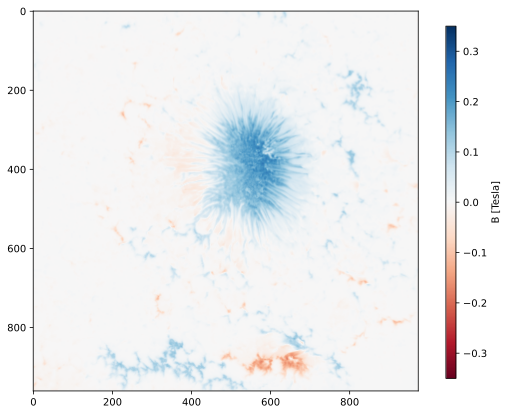

In [15]:
B = np.load("B.npy") * units.Unit("kg m / (s nm C)") # Load B-field values and apply units

fig, ax = plt.subplots(figsize=(7,7))
im_B = ax.imshow(B.to("Tesla"), vmin = -0.35, vmax=0.35, cmap = "RdBu");
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar_ax.tick_params(labelsize=10)
cbar = fig.colorbar(im_B, cax=cbar_ax)
cbar.set_label("B [Tesla]",size=10)

Here we can see that the magnetic field is not dependant of the granulations, and that there is almost no magnetic field in this area. There are a few spots, but they look like they might be randomly placed. The sunspot however has a strong magnetic field with the direction of the field towards us. We can also see that the pores are magentic, but only two of them has direction away from us, and one towards. From this we might think that the magnetic field of the pores are connected, since we know that a magnetic field line needs a north and a south pole, and that the fields here goes from one pore to the other. If this is true, and as we have seen earlier, many of the properties of the pores are equal to the sunspot, we might be lead to think that also the spots come in pairs or groups with opposite magentic field. This is however not something we can conclude on from these data, since we don't have more than one sunspot. We also observe a magnetic field directed out towards us in the granultion area to the left of the pores, which might have a connection to the pores, but this is only a guess.

If we look at the spectral line plot we produced earlier, we can see that the large values of broadning, of the spectral line profile, coincides with where the magnetic field is stronger, as we expected, since the Zeeman effect would be larger here.

We would expect the magnetic field plot and the variance plot to be very simular, at least if we look at the absolute value of the magnetic field. We can "blink" the two plots, or the absolute value of the $B-$field and the variance, and get a better idea of how similar they are.

In [16]:
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(10,10))
p = ax.imshow(np.abs(B.to("Tesla").value), vmin = -0.35, vmax=0.35, cmap = "RdBu")
q = ax.imshow(sigma2.value, cmap='RdBu')

anim = ArtistAnimation(fig, [[p], [q]], interval=1000, blit=True)
plt.close(fig)
HTML(anim.to_jshtml())

At first glance the two images don't look that simular since the general structure of the variance plot is littered with fluctuations, while the magnetic field plot is much more uniform. However, the large scale structures are still very similar. We can see that where the magnetic field is strong, there is generally an increase in the variance just as we would expect. What we have not been able to guess earlier is that the pores in the magnetic field plot each have a hole. These three holes have no magnetic field, but a very large variance. Maybe the highest values of the variance in the whole dataset. This is something that would be interesting for further investigation later, plotting the spectral line of each of these points to check the form of the absorption curve. It would also be interesting to do more measurements into these points later, to study other broadening effects.

Another couple of plots interesting to compare are the temperature and velocity plots. This we want to do in order to investigate how the movement of the matter has a connection with temperature.

In [17]:
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(10,10))
p = ax.imshow(T_b().value, cmap = "RdBu_r")
q = ax.imshow(v(v_los(lam0, lam_new),cos_theta).value,  vmax=4, vmin=-4,cmap='RdBu')

anim = ArtistAnimation(fig, [[p], [q]], interval=1000, blit=True)
plt.close(fig)
HTML(anim.to_jshtml())

When comapring these two plots, we observe that the matter is generally moving towards us in the granulations, where the temperature is at its largest, and moving away from us in the granulation lanes where the temperature is a bit lower. This indicates the known convection movement of the matter in the Sun, where energy is transported by hotter matter rising towards the surface, where it cools and again starts to sink. 

Lastly, we could be interested in comparing the magnetic field with the temperature in order to get a sense of and investigate if there are any correaltions between the two. 

In [18]:
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(10,10))
p = ax.imshow(B.to("Tesla").value, vmin = -0.35, cmap = "RdBu")
q = ax.imshow(T_b().value, cmap = "RdBu_r")

anim = ArtistAnimation(fig, [[p], [q]], interval = 1000, blit=True)
plt.close(fig)
HTML(anim.to_jshtml())

We can see here that the temperature is generally lower at large scale magnetic fields like the pores or the sunspot. We also know that the velocity in these places are generaly low. This indicates that the more active magnetic areas radiate less energy. To get a better understanding of this correlation it would be interesting to model the movement of matter in the area of such a strong magnetic field, but also try to observe the sunspots in different wavelength intervals to get a picture of the matter further into the Sun and farther out than what we can see here.

We have seen throught this project that the general temperature is proportional to the intensity of an area, meaning that a sunspot umbra and its surrounding penumbra have lower temperature than the granulation area. The umbra is also much cooler than the penumbra. We have also seen that the velocity is approximately zero at the umbra and pores but the penumbra has different movement at opposite sides of the umbra. The granulation areas have a velocity out of the surface at the granulations and into the surface in the lanes. Then we have seen that the variance and the magnetic field have large values for the umbra and for the pores, but low values for the penumbra and the granualtion areas. The variance increase in these areas are probably a direct result of the magnetic field through the Zeeman effect broadning the absorption line profile.